### Riya Sheth
riyasheth@uchicago.edu

In [9]:
#imports
import pandas as pd
from pandas_datareader import data
import numpy as np
import numpy as np
from sklearn import datasets, linear_model
import matplotlib.pyplot as plt
from enum import Enum

#enum
class Day(Enum):
    Holiday=1
    NotHoliday=0

In [62]:
#reading files
read_df = pd.read_csv("forecasts1.csv")
read_df.head()

,INTERVALSTARTTIME_GMT,INTERVALENDTIME_GMT,LOAD_TYPE,OPR_DT,OPR_HR,OPR_INTERVAL,MARKET_RUN_ID,TAC_AREA_NAME,LABEL,XML_DATA_ITEM,POS,MW,EXECUTION_TYPE,GROUP
0,2022-12-13T18:00:00-00:00,2022-12-13T19:00:00-00:00,2,2022-12-13,11,0,2DA,AVA,Demand Forecast 2-Day Ahead,SYS_FCST_2DA_MW,1.8,1688.57,2DA,1
1,2022-12-14T02:00:00-00:00,2022-12-14T03:00:00-00:00,2,2022-12-13,19,0,2DA,AVA,Demand Forecast 2-Day Ahead,SYS_FCST_2DA_MW,1.8,1738.27,2DA,1
2,2022-12-14T00:00:00-00:00,2022-12-14T01:00:00-00:00,2,2022-12-13,17,0,2DA,AVA,Demand Forecast 2-Day Ahead,SYS_FCST_2DA_MW,1.8,1728.37,2DA,1
3,2022-12-13T19:00:00-00:00,2022-12-13T20:00:00-00:00,2,2022-12-13,12,0,2DA,AVA,Demand Forecast 2-Day Ahead,SYS_FCST_2DA_MW,1.8,1670.56,2DA,1
4,2022-12-13T16:00:00-00:00,2022-12-13T17:00:00-00:00,2,2022-12-13,9,0,2DA,AVA,Demand Forecast 2-Day Ahead,SYS_FCST_2DA_MW,1.8,1716.38,2DA,1


In [63]:
weather_df= pd.read_csv("WeatherData.csv")
weather_df.head()

,Date,Time,Precipitation,Temperature
0,12/13/22,100,0.0,41.9
1,12/13/22,200,0.0,42.4
2,12/13/22,300,0.0,41.6
3,12/13/22,400,0.0,40.8
4,12/13/22,500,0.0,39.8


In [64]:
lmp_df = pd.read_csv("lmp.csv")
lmp_df.head()

,INTERVALSTARTTIME_GMT,INTERVALENDTIME_GMT,OPR_DT,OPR_HR,OPR_INTERVAL,NODE_ID_XML,NODE_ID,NODE,MARKET_RUN_ID,LMP_TYPE,XML_DATA_ITEM,PNODE_RESMRID,GRP_TYPE,POS,MW,GROUP
0,2022-12-13T11:00:00-00:00,2022-12-13T12:00:00-00:00,2022-12-13,4,0,0096WD_7_N001,0096WD_7_N001,0096WD_7_N001,DAM,LMP,LMP_PRC,0096WD_7_N001,ALL,1,332.01650,1
1,2022-12-14T03:00:00-00:00,2022-12-14T04:00:00-00:00,2022-12-13,20,0,0096WD_7_N001,0096WD_7_N001,0096WD_7_N001,DAM,LMP,LMP_PRC,0096WD_7_N001,ALL,1,433.74234,1
2,2022-12-13T18:00:00-00:00,2022-12-13T19:00:00-00:00,2022-12-13,11,0,0096WD_7_N001,0096WD_7_N001,0096WD_7_N001,DAM,LMP,LMP_PRC,0096WD_7_N001,ALL,1,271.25240,1
3,2022-12-13T21:00:00-00:00,2022-12-13T22:00:00-00:00,2022-12-13,14,0,0096WD_7_N001,0096WD_7_N001,0096WD_7_N001,DAM,LMP,LMP_PRC,0096WD_7_N001,ALL,1,249.25537,1
4,2022-12-14T07:00:00-00:00,2022-12-14T08:00:00-00:00,2022-12-13,24,0,0096WD_7_N001,0096WD_7_N001,0096WD_7_N001,DAM,LMP,LMP_PRC,0096WD_7_N001,ALL,1,355.33392,1


In [65]:
#creation_of_lists
list_year=[]
list_month=[]
list_day=[]
list_time=[]
list_holiday=[]
list_of_holiday= ["12/25", "12/31", "01/01", "07/04"]
list_precipitation=[]
list_temperature=[]
list_lmp=[]

#helper functions
def separate_date_time(x):
    year= x[0:4]
    month= x[5:7]
    day= x[8:10]
    starttime= x[11:13]
    list_year.append(year)
    list_month.append(month)
    list_day.append(day)
    list_time.append(starttime)
    return x

def check_holiday(x):
    month= month= x[5:7]
    day= x[8:10]
    counter=0
    for i in range(len(list_of_holiday)):
        if (month+"/"+day)== list_of_holiday[i]:
            list_holiday.append(1)
            counter= 1
    if counter==0:
        list_holiday.append(0)
    return x

def add_weather_metrics(x):
    #ignoring measuring year for now
    for i in range(len(weather_df)):
        month= month= x[5:7]
        day= x[8:10]
        starttime= int(x[11:13])*100
        if starttime==0:
            starttime=2400
        if (month+"/"+day+"/22").strip()== weather_df['Date'][i] and starttime== int(weather_df['Time'][i]):
            list_precipitation.append(weather_df['Precipitation'][i])
            list_temperature.append(weather_df['Temperature'][i])
            break        
    return x

def locational_marginal_prices(x):
    for i in range (len(lmp_df)):
        if x[0:13]== lmp_df['INTERVALSTARTTIME_GMT'][i][0:13]:
            list_lmp.append(lmp_df['MW'][i])
            break
    return x

In [66]:
#creation of dataframe for training
df= pd.DataFrame()

read_df['INTERVALSTARTTIME_GMT'].apply(separate_date_time)
read_df['INTERVALSTARTTIME_GMT'].apply(add_weather_metrics)
read_df['INTERVALSTARTTIME_GMT'].apply(check_holiday)
read_df['INTERVALSTARTTIME_GMT'].apply(locational_marginal_prices)

df['Year']= list_year
df['Month']= list_month
df['Day']= list_day
df['Time']= list_time
df['Forecasted Demand']= read_df['MW']
df['Precipitation']= list_precipitation
df['Temperature']= list_temperature
df['Holiday']= list_holiday
df['LMP']= list_lmp

df.head()

,Year,Month,Day,Time,Forecasted Demand,Precipitation,Temperature,Holiday,LMP
0,2022,12,13,18,1688.57,0.00,47.7,0,271.25240
1,2022,12,14,02,1738.27,0.02,53.9,0,449.11658
2,2022,12,14,00,1728.37,0.00,41.2,0,428.06018
3,2022,12,13,19,1670.56,0.00,44.1,0,257.95975
4,2022,12,13,16,1716.38,0.00,50.1,0,326.45132


In-Sample Error:  LMP    1974.234701
dtype: float64


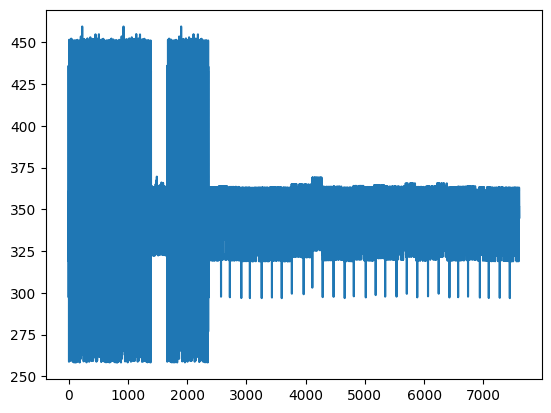

In [68]:
#linear regression
X_train=df[['Year','Month','Day','Time','Forecasted Demand', 'Precipitation', 'Temperature', 'Holiday']]
Y_train=df[['LMP']]

regr = linear_model.LinearRegression()
regr.fit(X_train, Y_train)

Y_pred= regr.predict(X_train)
ise_mse=  np.square(np.subtract(Y_train, Y_pred)).mean()

print("In-Sample Error: ", ise_mse)

In [47]:
#creation of dataset for testing out of sample
weather_df_test= pd.read_csv("WeatherData.csv")
forecasted_df_test = pd.read_csv("forecasts1.csv")


df_test= pd.DataFrame()
test_list_year=[2022]*24
test_list_month= [12]*24
test_list_day= [12]*24
test_list_time=[]
test_list_holiday=[0]*24
for i in range(1):
    for j in range(24):
        test_list_time.append(j)
        
test_list_precipitation= weather_df_test['Precipitation']
test_list_temperature= weather_df_test['Temperature']

test_list_forecasted=[]
for j in range(24):
    for i in range(len(forecasted_df_test)):
        x= forecasted_df_test['INTERVALSTARTTIME_GMT'][i]
        starttime= x[11:13]
        if int(starttime)== j:
            test_list_forecasted.append(forecasted_df_test['MW'][i])
            break
        

    
df_test['Year']= test_list_year
df_test['Month']= test_list_month
df_test['Day']= test_list_day
df_test['Time']= test_list_time
df_test['Forecasted Demand']= test_list_forecasted
df_test['Precipitation']= test_list_precipitation
df_test['Temperature']= test_list_temperature
df_test['Holiday']= test_list_holiday
df_test

Y_pred= regr.predict(df_test)


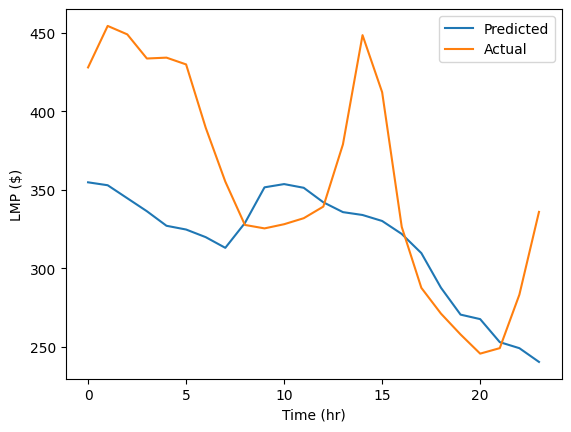

In [48]:
#plotting the results
lmp_df_test= pd.read_csv("lmp.csv")

Y_actual=[]
for j in range(24):
    for i in range(len(lmp_df_test)):
        x= lmp_df_test['INTERVALSTARTTIME_GMT'][i]
        starttime= x[11:13]
        if int(starttime)== j:
            Y_actual.append(lmp_df_test['MW'][i])
            break 

plt.plot(Y_pred, label="Predicted")
plt.plot(Y_actual, label="Actual")
plt.xlabel('Time (hr)')
plt.ylabel('LMP ($)')
plt.legend()
plt.show()

### Data Used for Training Model: 
1) 10th to 11th December, 2022 (Day Ahead Market) - CAISO, Location- Node 0096WD_7_N001 
2) 10th to 11th December, 2022 Precipitation and Average Temperature during each hour -  CIMIS  , Location- Los Angeles Basin

### Data Used for Testing of Model:
1) 12th December, 2022 (Day Ahead Market) - CAISO, Location- Node 0096WD_7_N001
2) 12th December, 2022 Precipitation and Average Temperature during each hour - CIMIS   , Location- Los Angeles Basin


### Next Steps
1. Different regression and machine learning models.
2. Thorough-testing by using data from longer periods.
3. More precise matching of the nodes and the locations.


### Questions
1. We need to use forecasted weather predictions for an actual prediction.
2. The smallest unit of time for the forecasted demand predictions is minutes while the prediction we output is every hour.
(average it for every hour)

3. The forecasted demand has no node, but lmp is nodewise, hence none of our independent variables have information about the node.
(node specific model, variable node's historical model, a feature which displays some of the node's characteristics)